## Utility variable

In [88]:
file_to_name = {
    'cc': 'Climate Change',
    's140': 'Sentiment 140',
    'mr': 'Movie Review'
}

## Analyzer extracting most common words

In [212]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

class Analyzer:
    def __init__(self, file):
        self.name = file_to_name[file]
        self.corpus = pd.read_pickle('ds_28nov/{}_clean_28nov.pkl'.format(file))
        self.positive = self.__get_split_corpus()
        self.negative = self.__get_split_corpus('negative')
        
        self.vectorizer = CountVectorizer(lowercase=False, max_df=0.7)
        
        self.bag = self.vectorizer.fit_transform(self.corpus.trimmed)
        self.positive_bag = self.vectorizer.transform(self.positive.trimmed)
        self.negative_bag = self.vectorizer.transform(self.negative.trimmed)
        
        self.vocabulary = None
        
    def __get_split_corpus(self, t = 'positive'):
        return self.corpus[self.corpus.target == t]
    
    def __create_top_words(self, bag):
        bag_sum = bag.sum(axis=0)
        vocabulary = [(w, bag_sum[0, i]) for w, i in self.vectorizer.vocabulary_.items()]
        return sorted(vocabulary, key = lambda x: x[1], reverse=True)
    
    def get_random_examples(self, n=5, fr='all'):
        if fr == 'all':
            return self.corpus.sample(n).text
        elif fr == 'positive':
            return self.positive.sample(n).text
        else:
            return self.negative.sample(n).text
        
    def get_top_words(self, n=20, fr='all'):
        if self.vocabulary is None:
            self.vocabulary = {
                'all': self.__create_top_words(self.bag),
                'positive': self.__create_top_words(self.positive_bag),
                'negative': self.__create_top_words(self.negative_bag)
            }
        return self.vocabulary[fr][:n]

In [226]:
import numpy as np

class CommonAnalyzer:
    def __init__(self):
        self.analyzers = []
        self.added = False
        self.intersec = None
    
    def add(self, analyzer):
        self.analyzers.append(analyzer)
        self.added = True
    
    def get_top_words(self, n=20, fr='all'):
        if self.intersec is None or self.added:
            self.added = False
            self.intersec = {
                'all': None,
                'positive': None,
                'negative': None
            }
            for fr in ['all', 'positive', 'negative']:
                for analyzer in self.analyzers:
                        words, counts = zip(*analyzer.vocabulary[fr])
                        if self.intersec[fr] is None:
                            self.intersec[fr] = words
                        else:
                            self.intersec[fr] = np.intersect1d(self.intersec[fr], words, assume_unique=True)
                self.intersec[fr] = sorted(self.intersec[fr], key = lambda x: counts[words.index(x)], reverse=True)
                
        return self.intersec[fr][:n]
            

In [227]:
import matplotlib.pyplot as plt

def plot_top_words(analyzer, n=20, fr='all'):
    x, y = zip(*analyzer.get_top_words(n, fr))
    plt.figure(figsize=(15, n // 4))
    plt.barh(x[::-1], y[::-1])
    plt.margins(y=0.01)
    plt.grid(True, axis='x')
    plt.ylabel('Words')
    plt.xlabel('Frequency')
    plt.title("Most common words in {} corpus of {}".format(fr, analyzer.name))
    plt.show()
    
def plot_all_top_words(analyzer, n=20):
    for fr in ['all', 'positive', 'negative']:
        plot_top_words(analyzer, n, fr)

## Exploratory Data Analysis 

### Most common words of each corpus

Climate Change


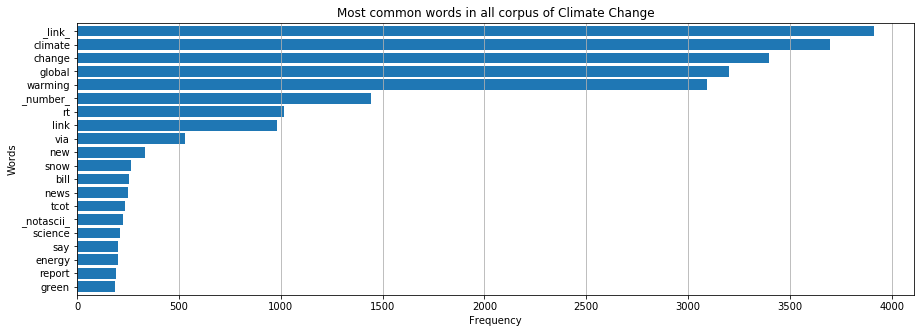

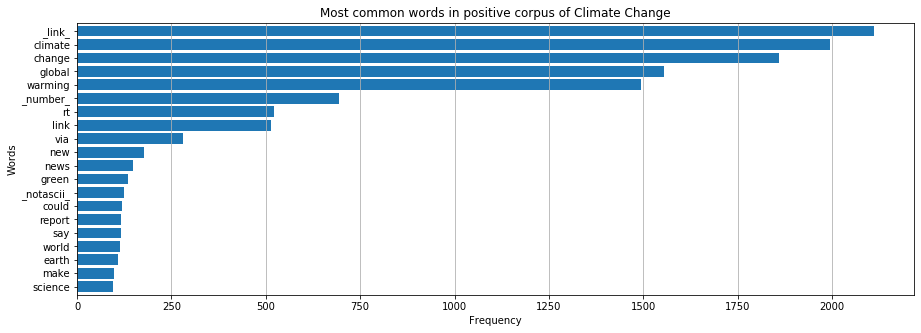

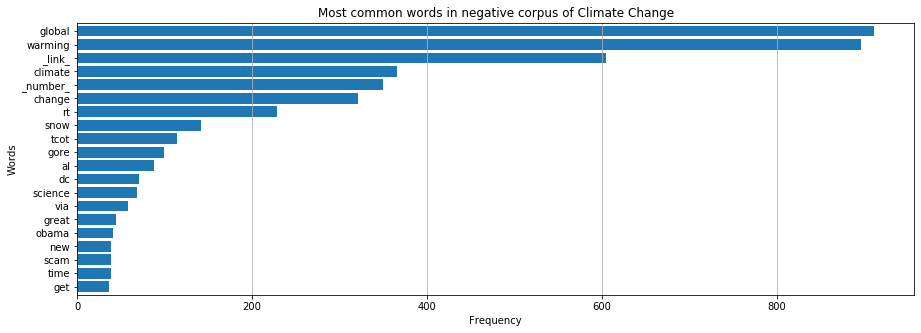

Movie Review


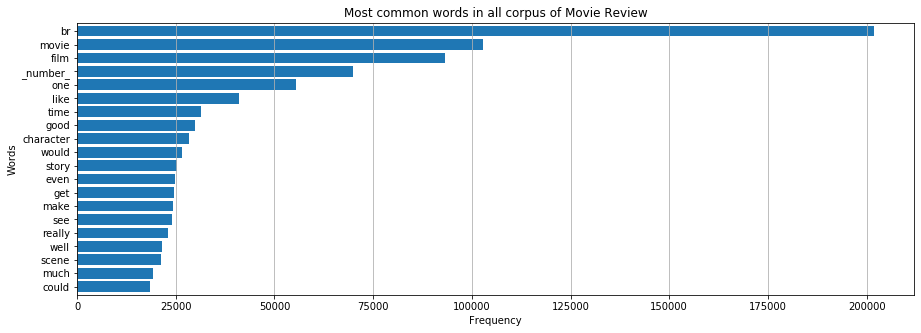

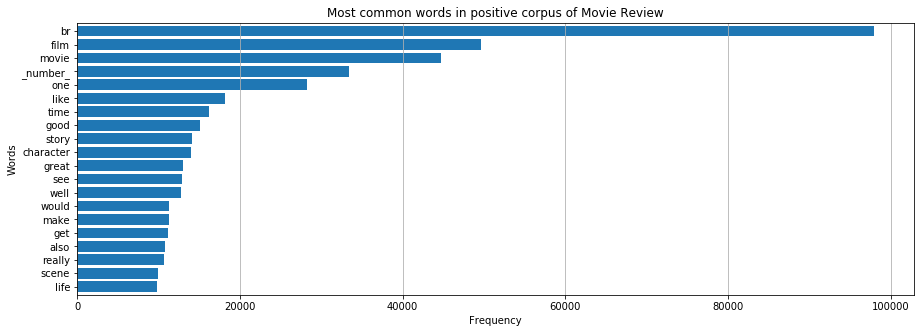

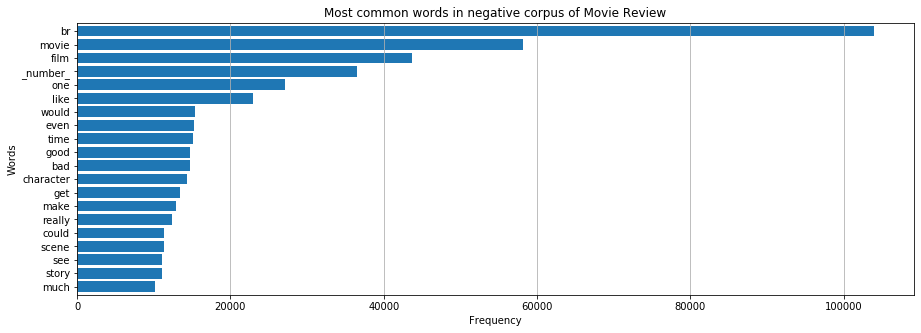

Sentiment 140


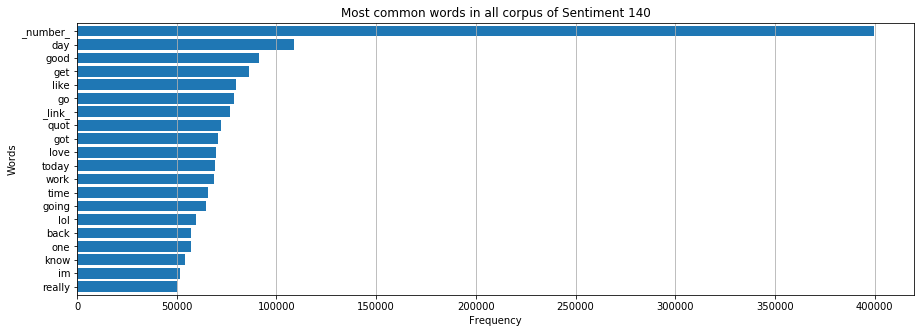

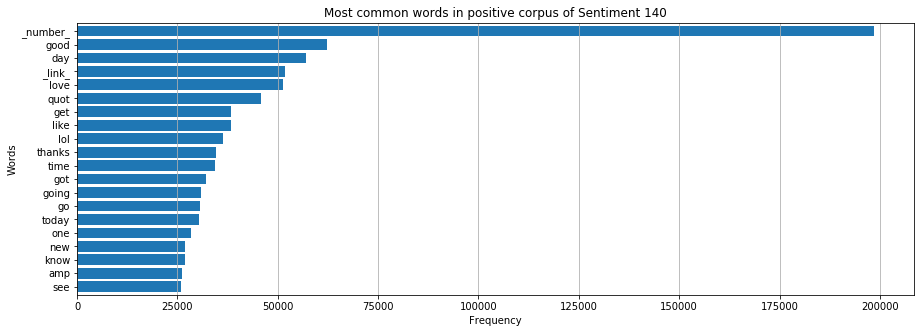

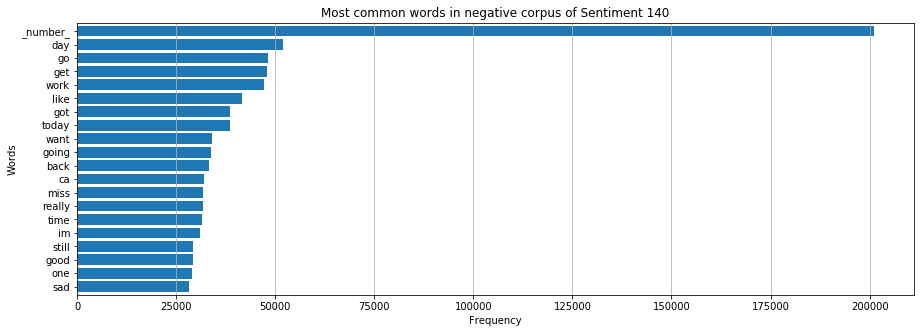

In [228]:
analyzers = CommonAnalyzer()

for file in ['cc', 'mr', 's140']:
    print(file_to_name[file])
    analyzer = Analyzer(file)
    analyzers.add(analyzer)
    plot_all_top_words(analyzer, n=20)

### Some of the most common words present in all corpus

In [240]:
for fr in ['all', 'positive', 'negative']:
    print("=" * (len(fr) + 34))
    print("| Some of the most common {} words |".format(fr))
    print("=" * (len(fr) + 34))
    print(analyzers.get_top_words(n=30, fr=fr))

| Some of the most common all words |
['_number_', 'day', 'good', 'get', 'like', 'go', '_link_', 'got', 'love', 'today', 'work', 'time', 'going', 'lol', 'back', 'one', 'know', 'im', 'really', 'want', 'ca', 'see', 'night', 'think', 'still', 'oh', 'well', 'new', 'na', 'home']
| Some of the most common positive words |
['_number_', 'good', 'day', '_link_', 'love', 'get', 'like', 'lol', 'thanks', 'time', 'got', 'going', 'go', 'today', 'one', 'new', 'know', 'see', 'great', 'night', 'll', '_notascii_', 'back', 'well', 'haha', 'work', 'morning', 're', 'think', 'happy']
| Some of the most common negative words |
['_number_', 'day', 'go', 'get', 'work', 'like', 'got', 'today', 'want', 'going', 'back', 'ca', 'miss', 'really', 'time', 'im', 'still', 'good', 'one', 'sad', 'know', 'na', 'need', 'feel', '_link_', 'home', 'oh', 'wish', 'lol', 'think']


### Example of sentences

In [225]:
for fr in ['all', 'positive', 'negative']:
    print('=' * (len(fr) + 25))
    print("| Examples of {} examples |".format(fr))
    print('=' * (len(fr) + 25))
    for analyzer in analyzers.analyzers:
        print(analyzer.name)
        print('-' * 20)
        for i, sentence in enumerate(analyzer.get_random_examples(n=2, fr='positive')):
            print("{}. {}".format(i+1, sentence))
        print()

| Examples of all examples |
Climate Change
--------------------
1. 5th US Climate Action Report Released: "Global Warming is Unequivocal": Treehugger by Brian Merchant, Brooklyn, Ne... [link]
2. Yachtsmen's marine paradise hit by global warming|The yachtsman's wildlife ocean paradise of the Galapagos .. http://oohja.com/x6CPN

Movie Review
--------------------
1. My favourite movie of all time. This was a flawed piece of work by Coppola and seeing the documentary 'Heart of Darkness' made it even more compelling. Coppola at this point was king of Hollywood after making 'the Godfather' and 'GodfatherII' and had developed the ego necessary to even dare try to make a movie like 'Apocalypse Now'. Through sheer arrogance he went to the Phillipines with a partial script and thought he would know what he would do when he got there. Just as Captain Willard thought he would know what to do once he got to Col. Kurtz's compound. And just like Willard, he DIDN'T know what he was going to do once h